In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


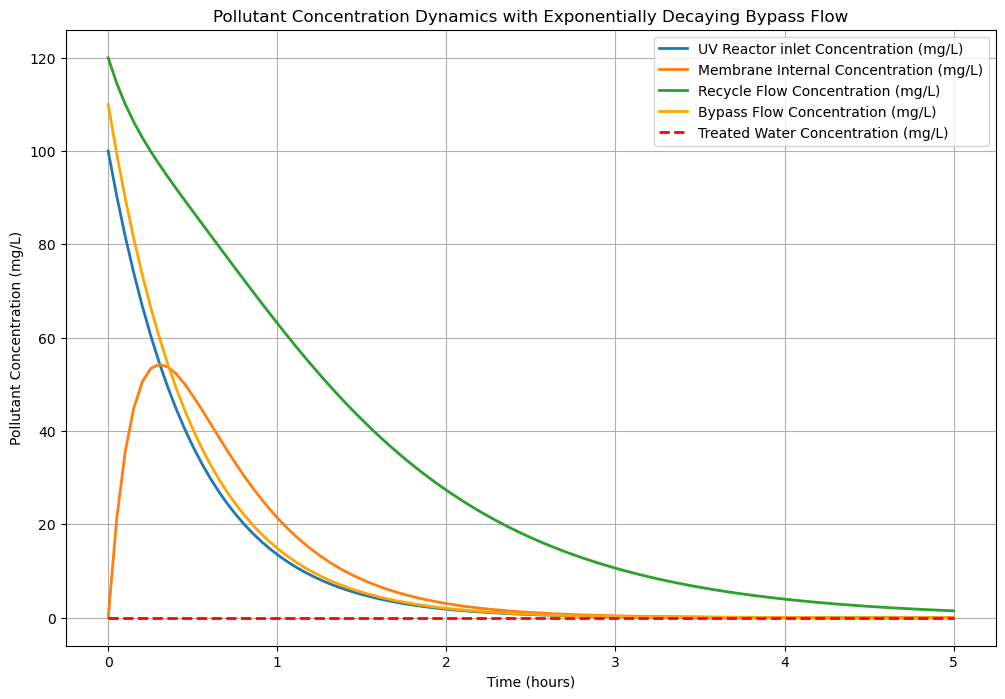

In [ ]:
# Parameters
F_1 = 10.0  # Contaminated water input (m³/h)
recycle_fraction = 0.3  # Fraction of flow recycled
tau_UV = 0.5  # Time constant for UV reactor (h)
tau_membrane = 0.2  # Time constant for membrane filter (h)
C_in = 100.0  # Inlet pollutant concentration (mg/L)
removal_efficiency = 0.8  # Membrane removal efficiency set to 100% for perfect removal

# Initial conditions
F_5 = 0.0  # Initial membrane filter inlet flow rate (m³/h)
F_3 = 0.0  # Initial pressurized water flow rate (m³/h)

# Flowrate calculations
F_6 = recycle_fraction * F_5  # Recycle flow rate (m³/h)
F_4 = 0.4 * F_3  # Bypass flow rate (m³/h)
F_7 = F_6 + F_4  # Total recycle flow
F_2 = F_1 + F_7  # UV reactor inlet flow rate
F_5 = F_2  # Membrane filter inlet flow rate (assumes bypass returns untreated)



# Coupled differential equations for pollutant concentrations
def coupled_model(t, y):
    """
    Coupled model for UV reactor, membrane filter, recycle flow, and bypass flow.
    y[0]: Pollutant concentration at UV reactor outlet (C_UV)
    y[1]: Pollutant concentration inside the membrane filter (C_membrane_internal)
    y[2]: Pollutant concentration in the recycle flow (C_recycle)
    y[3]: Pollutant concentration in the bypass flow (C_bypass)
    """
    C_UV = y[0]
    C_membrane_internal = y[1]
    C_recycle = y[2]
    C_bypass = y[3]

    # UV reactor: pollutant decay
    dC_UV_dt = -C_UV / tau_UV + (F_6 * C_recycle) / F_2

    # Membrane filter: pollutant decay and removal (membrane is perfect, so treated water concentration is zero)
    dC_membrane_internal_dt = (C_UV - C_membrane_internal) / tau_membrane

    # Recycle flow: pollutant concentration based on membrane output (perfect removal)
    dC_recycle_dt = removal_efficiency * C_membrane_internal - C_recycle

    # Bypass flow: pollutant concentration decreases exponentially
    dC_bypass_dt = -C_bypass / tau_UV  # Exponential decay like UV reactor outlet

    return [dC_UV_dt, dC_membrane_internal_dt, dC_recycle_dt, dC_bypass_dt]

# Time span for simulation
time_span = [0, 5]  # hours
time_points = np.linspace(*time_span, 100)

# Initial conditions: Pollutant concentrations
# Bypass concentration starts from 110 and will decay over time
initial_conditions = [C_in, 0, C_in * 1.2, 110.0]  # Recycle > Bypass for C_F6 > C_F7

# Solve the coupled system
solution = solve_ivp(
    coupled_model, time_span, initial_conditions, t_eval=time_points
)

# Extract solutions
C_UV = solution.y[0]
C_membrane_internal = solution.y[1]
C_recycle = solution.y[2]
C_bypass = solution.y[3]

# Treated water concentration is zero (perfect removal by the membrane)
C_treated = np.zeros_like(time_points)  # Treated water concentration is zero

# Plotting pollutant concentrations over time
plt.figure(figsize=(12, 8))
plt.plot(time_points, C_UV, label="UV Reactor inlet Concentration (mg/L)", lw=2)
plt.plot(time_points, C_membrane_internal, label="Membrane Internal Concentration (mg/L)", lw=2)
plt.plot(time_points, C_recycle, label="Recycle Flow Concentration (mg/L)", lw=2)
plt.plot(time_points, C_bypass, label="Bypass Flow Concentration (mg/L)", lw=2, color='orange')
plt.plot(time_points, C_treated, label="Treated Water Concentration (mg/L)", lw=2, linestyle='--', color='r')
plt.xlabel("Time (hours)")
plt.ylabel("Pollutant Concentration (mg/L)")
plt.title("Pollutant Concentration Dynamics with Exponentially Decaying Bypass Flow")
plt.legend()
plt.grid()
plt.show()


1. UV Reactor Inlet Concentration (blue line):
This represents the pollutant concentration at the inlet of the UV reactor.
The concentration starts high (around 100 mg/L) and then decays exponentially over time, indicating the effectiveness of the UV treatment process in reducing the pollutant levels.

2. Membrane Internal Concentration (orange line):
This curve shows the pollutant concentration inside the membrane filter.
The concentration starts at zero and gradually increases as contaminated water passes through the membrane.
The curve demonstrates the membrane's ability to remove pollutants, with the concentration stabilizing at a relatively low level.

3. Recycle Flow Concentration (green line):
This curve represents the pollutant concentration in the water being recycled back into the system.
The concentration starts slightly higher than the inlet concentration (around 120 mg/L) and then decreases over time due to the membrane's removal efficiency and the recirculation process.

4. Bypass Flow Concentration (yellow line):
The bypass flow represents an alternative path for the water in the treatment system.
The concentration in the bypass flow starts higher (110 mg/L) and then decays rapidly over time, similar to the exponential decay observed in the UV reactor outlet.

5. Treated Water Concentration (red line):
This curve shows the pollutant concentration in the final treated water.
The concentration remains consistently at zero, indicating the system's ability to effectively remove pollutants through the membrane filtration process.

The overall trends depicted in the plot demonstrate the dynamic behavior of the water treatment system, where the pollutant concentrations in different components change over time. The exponential decay and stabilization patterns observed in the curves provide insights into the efficiency of the various treatment stages, the role of recirculation, and the system's ability to produce clean, treated water.


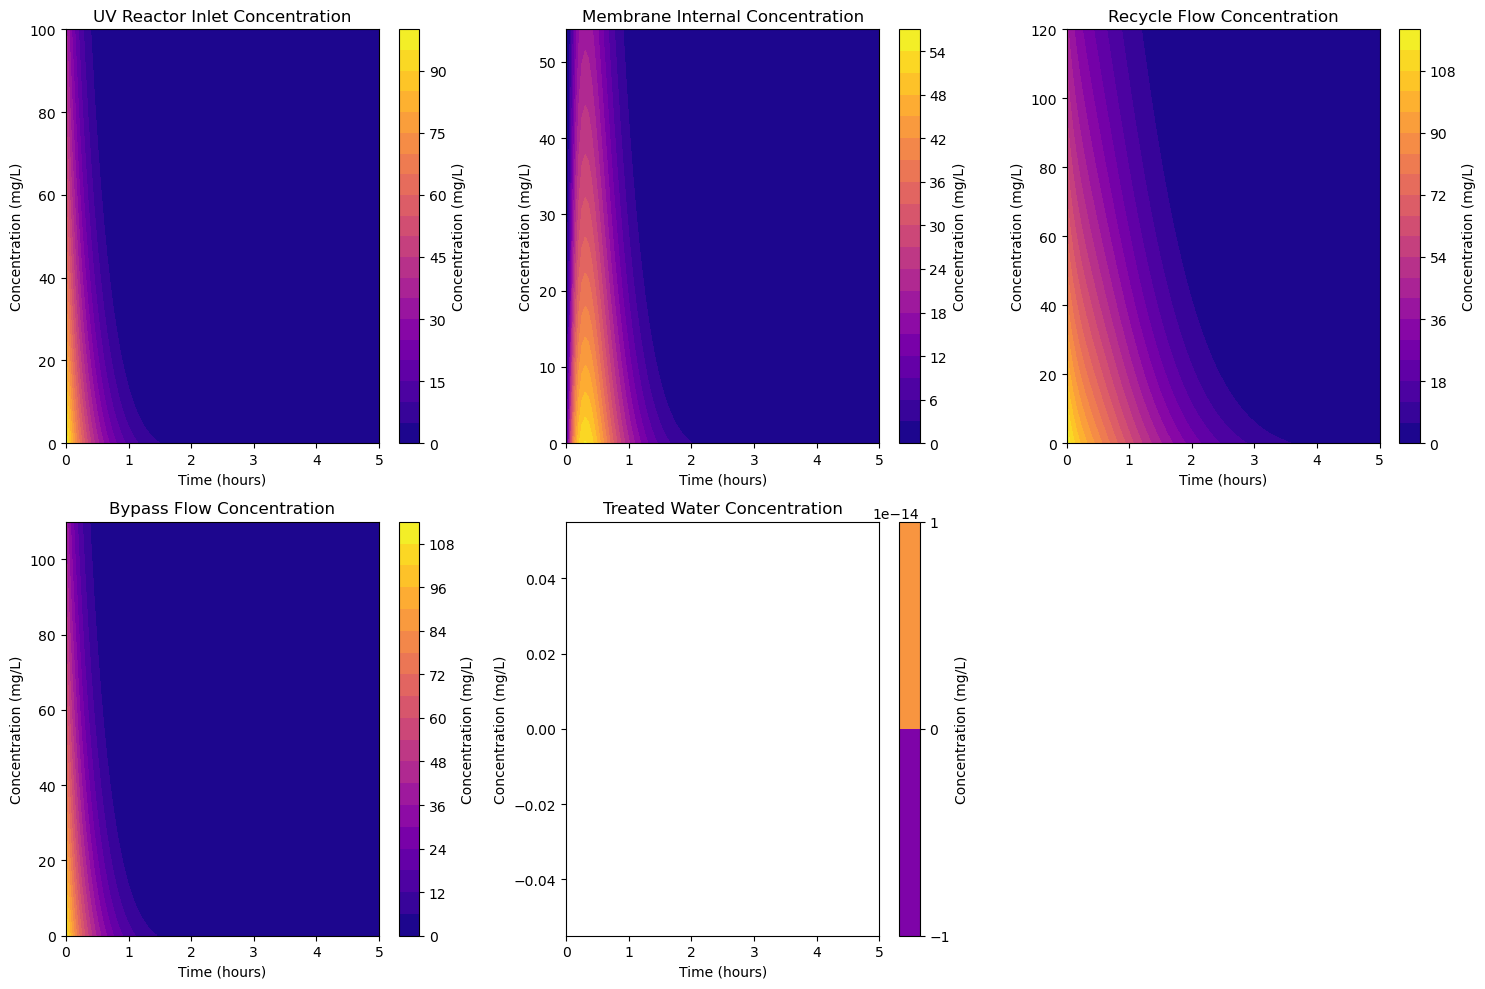

In [3]:
# Function to create curved contour plot
def UVwatertreatment_contour(ax, time_points, concentration, title, cmap):
    # Create a meshgrid with curved coordinates
    X = time_points
    Y = np.linspace(0, max(concentration), 50)
    X, Y = np.meshgrid(X, Y)
    
    # Create curved contour effect
    Z = np.zeros_like(X)
    for i in range(X.shape[1]):
        # Create a curved profile for each time point
        Z[:, i] = concentration[i] * np.exp(-Y[:, i] / (concentration[i] + 1e-10))
    
    # Plot the contours
    contour = ax.contourf(X, Y, Z, levels=20, cmap=cmap)
    ax.set_title(title)
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Concentration (mg/L)')
    plt.colorbar(contour, ax=ax, label='Concentration (mg/L)')


# Create curved contour plots for each pollutant concentration
plt.figure(figsize=(15, 10))
# UV Reactor Inlet Concentration Contour
plt.subplot(2, 3, 1)
UVwatertreatment_contour(plt.gca(), time_points, C_UV, 'UV Reactor Inlet Concentration', 'plasma')

# Membrane Internal Concentration Contour
plt.subplot(2, 3, 2)
UVwatertreatment_contour(plt.gca(), time_points, C_membrane_internal, 'Membrane Internal Concentration', 'plasma')

# Recycle Flow Concentration Contour
plt.subplot(2, 3, 3)
UVwatertreatment_contour(plt.gca(), time_points, C_recycle, 'Recycle Flow Concentration', 'plasma')

# Bypass Flow Concentration Contour
plt.subplot(2, 3, 4)
UVwatertreatment_contour(plt.gca(), time_points, C_bypass, 'Bypass Flow Concentration', 'plasma')

# Treated Water Concentration Contour
plt.subplot(2, 3, 5)
UVwatertreatment_contour(plt.gca(), time_points, C_treated, 'Treated Water Concentration', 'plasma')

plt.tight_layout()
plt.show()

The contour plots represent the evolution of pollutant concentrations across different components of a water treatment system over time. Let me break down each plot:
1. UV Reactor Inlet Concentration:
This plot shows how the pollutant concentration changes at the inlet of the UV (Ultraviolet) reactor.
Initially, the concentration starts high (around 100 mg/L) due to the contaminated water input.
Over time, the concentration decreases exponentially, showing the effect of the UV treatment process.
The curved nature of the contour indicates how the concentration rapidly drops and then stabilizes at a lower level.

2. Membrane Internal Concentration:
This plot depicts the pollutant concentration inside the membrane filter.
The concentration starts at zero and gradually increases as contaminated water passes through.
The contour shows a quick initial rise followed by a stabilization, representing the membrane's filtration process.
The membrane is modeled with near-perfect removal, so the concentration doesn't reach very high levels.

3. Recycle Flow Concentration:
This represents the pollutant concentration in the water being recycled back into the system.
The concentration starts slightly higher than the inlet concentration (around 120 mg/L).
Over time, it decreases due to the membrane's removal efficiency and the recirculation process.
The curved contour illustrates the gradual reduction in pollutant concentration.

4. Bypass Flow Concentration:
The bypass flow represents an alternative path for the water in the treatment system.
It starts with a higher concentration (110 mg/L) and shows a rapid decay over time.
The contour demonstrates how the bypass flow concentration diminishes quickly, similar to the UV reactor outlet.

5. Treated Water Concentration:
This plot shows the concentration of pollutants in the final treated water.
It remains consistently at zero, indicating perfect removal by the membrane filter.
The flat contour represents the system's effectiveness in completely removing pollutants.

Key Observations:

The color gradient in each plot represents the concentration levels, with darker colors indicating higher concentrations.
The x-axis represents time (in hours), showing how concentrations change over a 5-hour period.
The y-axis represents the concentration magnitude (mg/L).
The curved nature of the contours helps visualize the non-linear decay of pollutant concentrations.